In [11]:

#the essentials for deep_learning
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, MaxPooling2D

#going to use tensorflow datasets for easy access to the CIFAR-10 datasets
#could have just as easily used keras dataset instead
import tensorflow_datasets as tfds

#for visualizing of results, specifically validation accuracy
from matplotlib import pyplot as plt


In [32]:
"""
created a dataset and training_set variable that basically acts as a 
pipeline to the cifar10 training split provided by tensorflow datasets

"""

training_set = tfds.load('cifar10', split = 'train')
testing_set = tfds.load('cifar10', split = 'test')

#doing the preprocessing

def scale_images(data): 
    image = data['image']
    label = data['label']
    return image / 255, label



#used the scale_image to normalize RGB values between 0 and 1
training_set = training_set.map(scale_images) 
testing_set = testing_set.map(scale_images)








In [33]:



#for both test and train datasets, I just shuffled the order

training_set = training_set.shuffle(60000)
testing_set = testing_set.shuffle(10000)

#seperated them into batches

training_set = training_set.batch(128)
testing_set  = testing_set.batch(128)

"""
#start fetching another batch while the current batch is being processed 
#by the model. The amount of batches is determined automatically based 
"""
training_set = training_set.prefetch(tf.data.AUTOTUNE)
testing_set = testing_set.prefetch(tf.data.AUTOTUNE)



#caching the datasets so that there's no need to re-preprocess between epochs
training_set = training_set.cache()
testing_set = testing_set.cache()

In [64]:

#making the model

model = Sequential()

"""
for the first nine layers I have a series of:
A convolution layer of 16,32,64 filters respectively, each with a 3by3 kernel
 - I chose a 3 by 3 kernel because it seemed like a general theme in google
 - I chose LeakyRelu instead of Relu so I could deal with the dying ReLU problem
A dropout layer to prevent overfitting and keep the CNN on it's toes
Finally a max pooling layer to reduce computational cost
"""
model.add(Conv2D(32, (2,2),activation =LeakyReLU(0.2), input_shape=(32,32,3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3),activation =LeakyReLU(0.2)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3),activation =LeakyReLU(0.2)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2)))
"""
For the next two layers I:
Flattened and passed to a fully connected layer
The dense layer which had an activation function of leakyReLU
Another dropout layer to prevent overfitting
Finally the classification layer with 10 nuerons (for 10 classes in cifar10)
 - Used softmax as activation so it would give me probabilities for each class label

"""

model.add(Flatten())
model.add(Dense(256, activation =LeakyReLU(0.2)))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 31, 31, 32)        416       
                                                                 
 dropout_64 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 dropout_65 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                

In [66]:
"""
Used sparse_categorical crossentrophy for the loss function because I needed
a probabilistic loss function and my options were categorical, binary, or
sparse_categorical. I ruled out binary because there were more than two classes,
and since the cifar dataset comes with integer labels, sparse_categorical makes 
more sense.


I used ada as my optimizer, while I believe I should have SGD instead, because 
adam performs well on the training set, but generalizes worse
then SGD on the testing set, however adam is faster and it has an adaptive 
learning rate, so that's what I'm going to be using
"""

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', \
              metrics = ['accuracy'])



In [69]:
#setting up the callback directory
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

"""
actually training the model, passing in the training_set and the validation set,
also letting it go for 20 epochs, because that is what many of the tuturials 
recommended, also used the callbacks feature to specifically a callback directory
so I can go back to the model at different points in it's training
"""

hist = model.fit(training_set, epochs=20, \
                 validation_data=testing_set, \
                 callbacks=[tensorboard_callback])

Epoch 1/20
391/391 [==============================] - 3s 8ms/step - loss: 0.7912 - accuracy: 0.7233 - val_loss: 0.8906 - val_accuracy: 0.6934
Epoch 2/20
391/391 [==============================] - 3s 8ms/step - loss: 0.7740 - accuracy: 0.7307 - val_loss: 0.8641 - val_accuracy: 0.7007
Epoch 3/20
391/391 [==============================] - 4s 9ms/step - loss: 0.7562 - accuracy: 0.7342 - val_loss: 0.8769 - val_accuracy: 0.6995
Epoch 4/20
391/391 [==============================] - 3s 8ms/step - loss: 0.7389 - accuracy: 0.7418 - val_loss: 0.8852 - val_accuracy: 0.6988
Epoch 5/20
391/391 [==============================] - 3s 8ms/step - loss: 0.7238 - accuracy: 0.7467 - val_loss: 0.8730 - val_accuracy: 0.6981
Epoch 6/20
391/391 [==============================] - 3s 8ms/step - loss: 0.7131 - accuracy: 0.7517 - val_loss: 0.8202 - val_accuracy: 0.7157
Epoch 7/20
391/391 [==============================] - 3s 9ms/step - loss: 0.6982 - accuracy: 0.7562 - val_loss: 0.8667 - val_accuracy: 0.7073
Epoch 

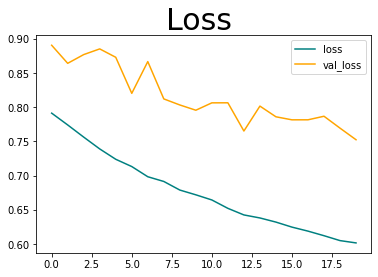

In [70]:
#using pyplot to plot out the loss and validation loss
plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
plt.suptitle('Loss', fontsize = 30)
plt.legend(loc='upper right')
plt.show()

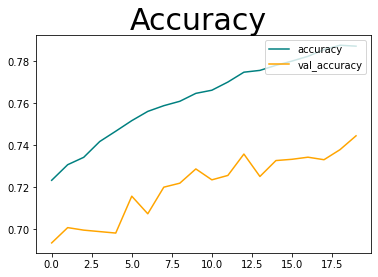

In [71]:
# using pyplot to plot out the accuracy and validation accuracy
plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.suptitle('Accuracy', fontsize = 30)
plt.legend(loc='upper right')
plt.show()